# Advance Lane finding project

The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Camera calibration
### In this section, camera is calibrated using provided calibration images

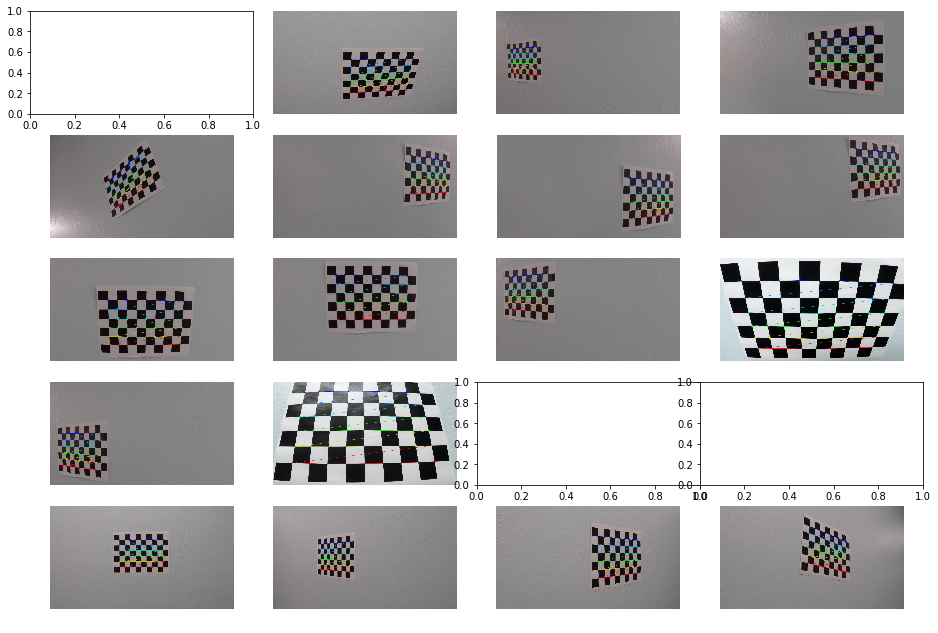

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

imgs = glob.glob('camera_cal/calibration*.jpg')

objpoints = []
imgpoints  = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i, fname in enumerate(imgs):

    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    #print(ret)

    if ret == True:
        #print(fname)
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)
plt.show()

#pickle.dump( objpoints, open( "obj.p", "wb" ) )
#pickle.dump( imgpoints, open( "img.p", "wb" ) )

f = open("save.p","wb")
pickle.dump(objpoints, f )
pickle.dump(imgpoints, f )

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
pickle.dump(mtx, f)
pickle.dump(dist, f)
f.close()

# Image undistortion
   
   Next, using the object and image points from camera callibration, the images are undistorted. An example of undistortion of image is provided below. One of the provided calibration images is undistorted using the calibration points.

In [3]:
def cal_undistort(img):

    #Load saved data
    f = open('save.p','rb')
    objpts = pickle.load(f)
    imgpts = pickle.load(f)
    mtx = pickle.load(f)
    dist = pickle.load(f)
    f.close()
    
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)

    return dst


## Distortion correction example

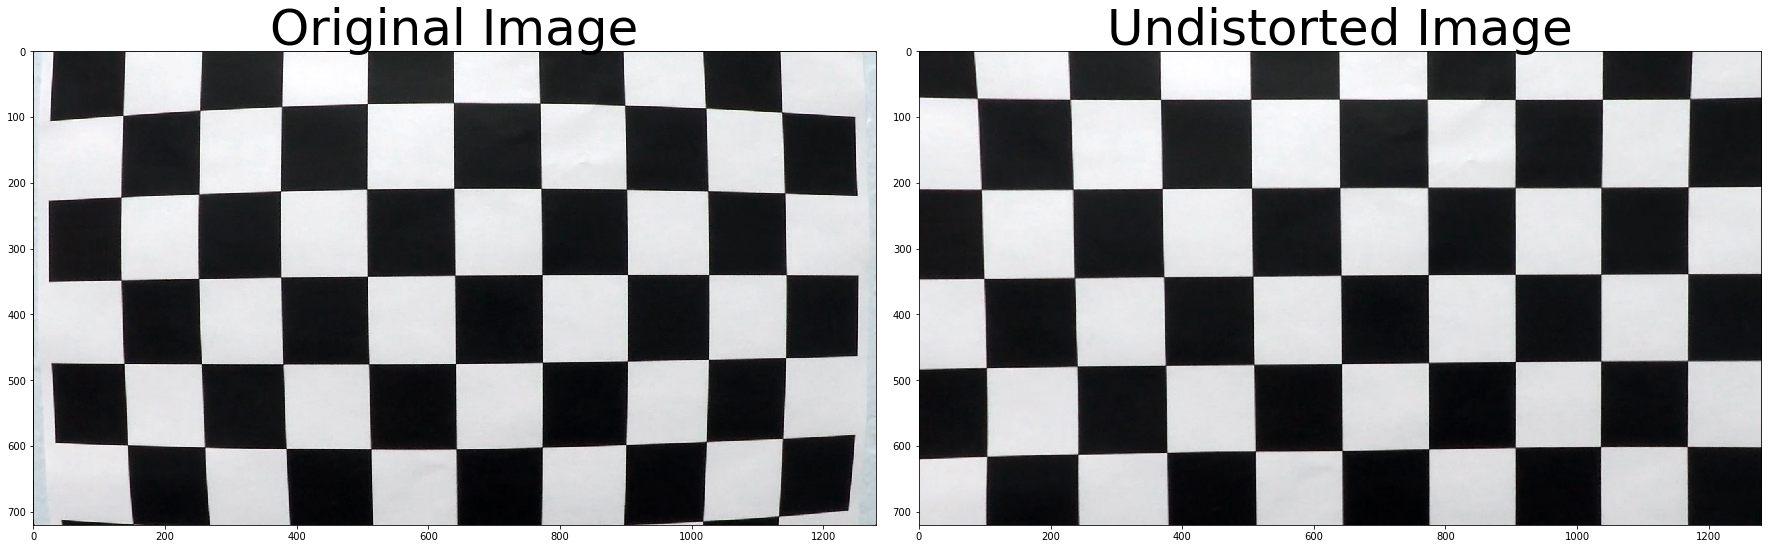

In [4]:
#Test image undistortion

tst_img = cv2.imread('camera_cal/calibration1.jpg')

plt.imshow

dst = cal_undistort(tst_img)
cv2.imwrite('output_images/undist.jpg', dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(tst_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


## Perspective transformation
 The undistorted image is then transformed to bird eye view using perpective transform. Source and destination points are chosen using trial and error method.

In [5]:
def corners_unwarp(image, nx, ny):    
    w = image.shape[1]
    h = image.shape[0]
    
    #Load saved data
    f = open('save.p','rb')
    mtx = pickle.load(f)
    dist = pickle.load(f)
    f.close()
    
    x,y = 0.5*w, 0.8*h
      
    # Source coordinates. Not used
    src = np.float32([
            [w * 0.4475, h * 0.65],
            [w * 0.5525, h * 0.65],
            [w * 0.175, h * 0.95],
            [w * 0.825, h * 0.95],
        ])
    
    # Destination coordinates. Not used
    dst = np.float32([
            [w * 0.2, h * 0.025],
            [w * 0.8, h * 0.025],
            [w * 0.2, h * 0.975],
            [w * 0.8, h * 0.975],
        ])
    
    # Source coordinates. These co-ordinates work better and are actually used.
    src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
    
    # Destination coordinates. These co-ordinates work better and are actually used.
    dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])

    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]))

    return warped, Minv

## Example of perspective transformation of undostorted test images
 The provided test images are unditorted and perpective transformed for visualization.

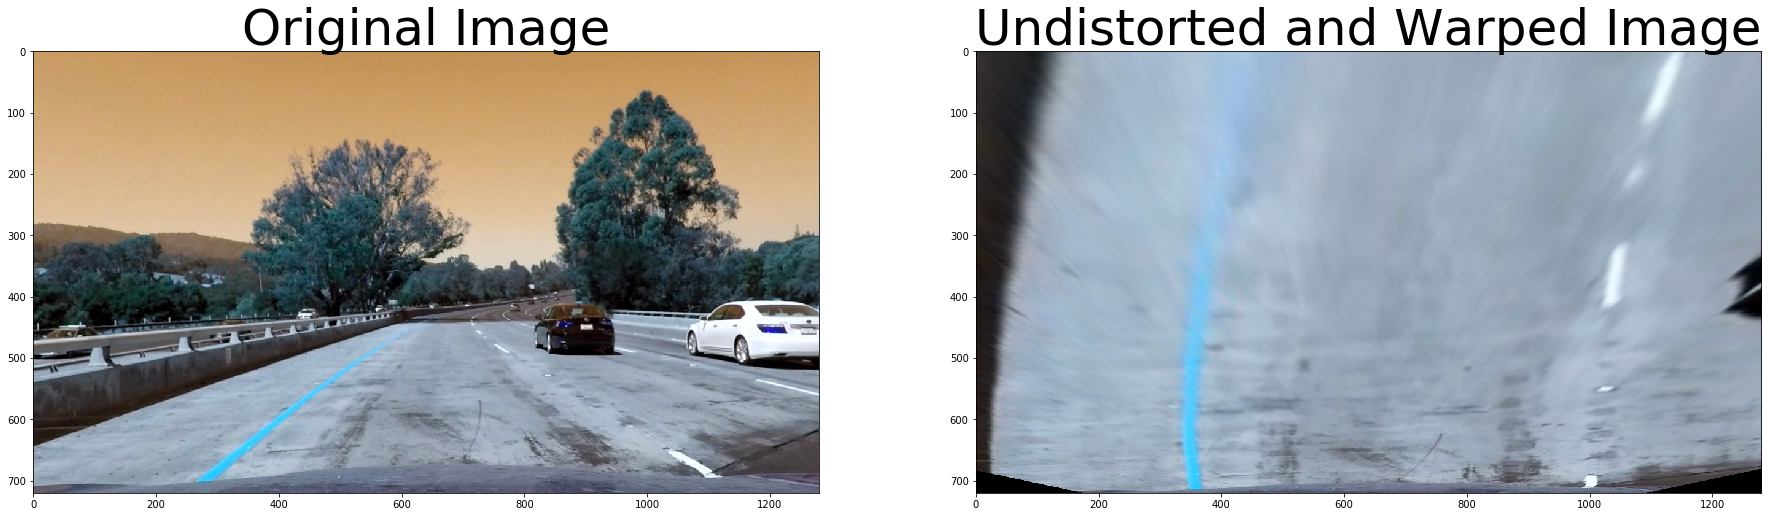

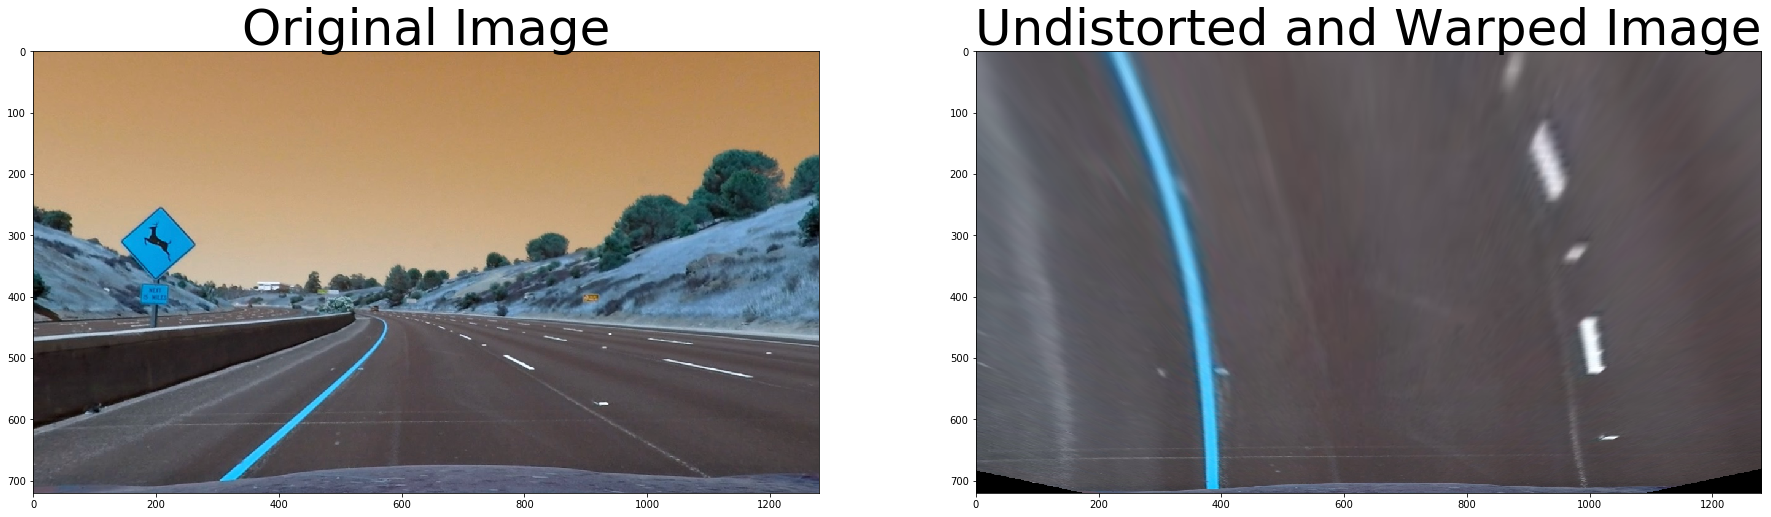

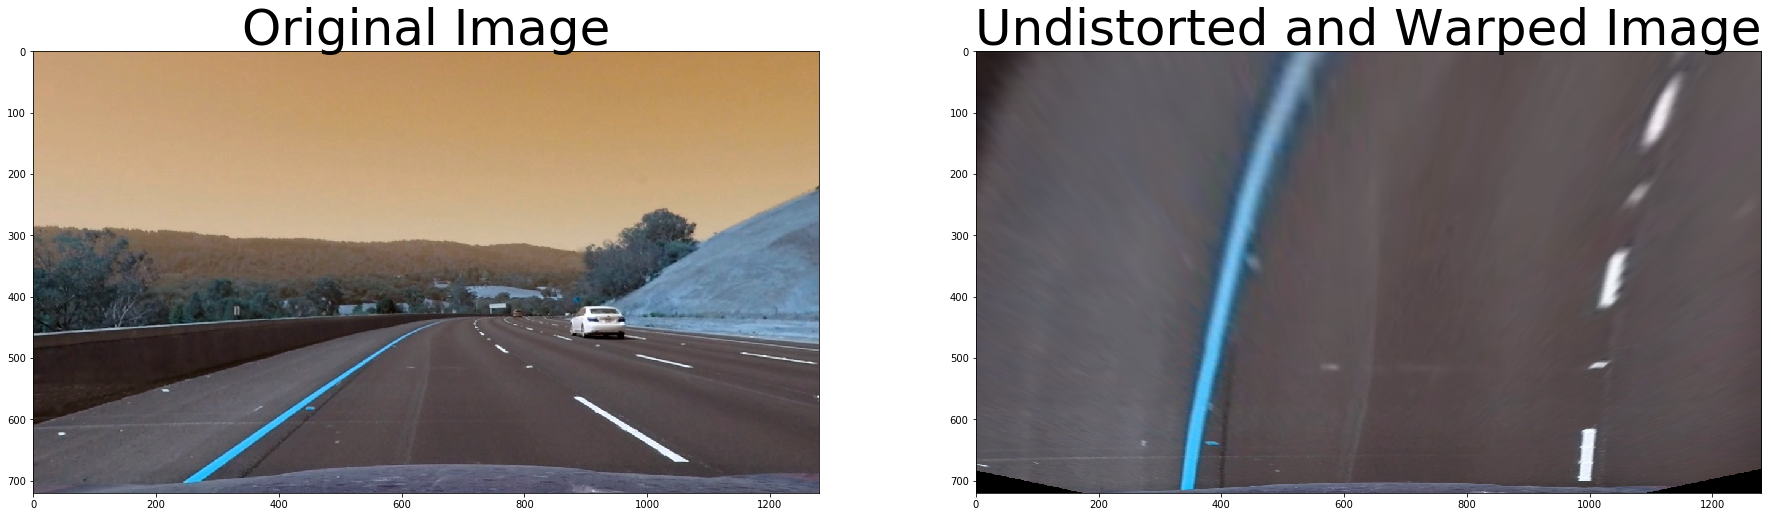

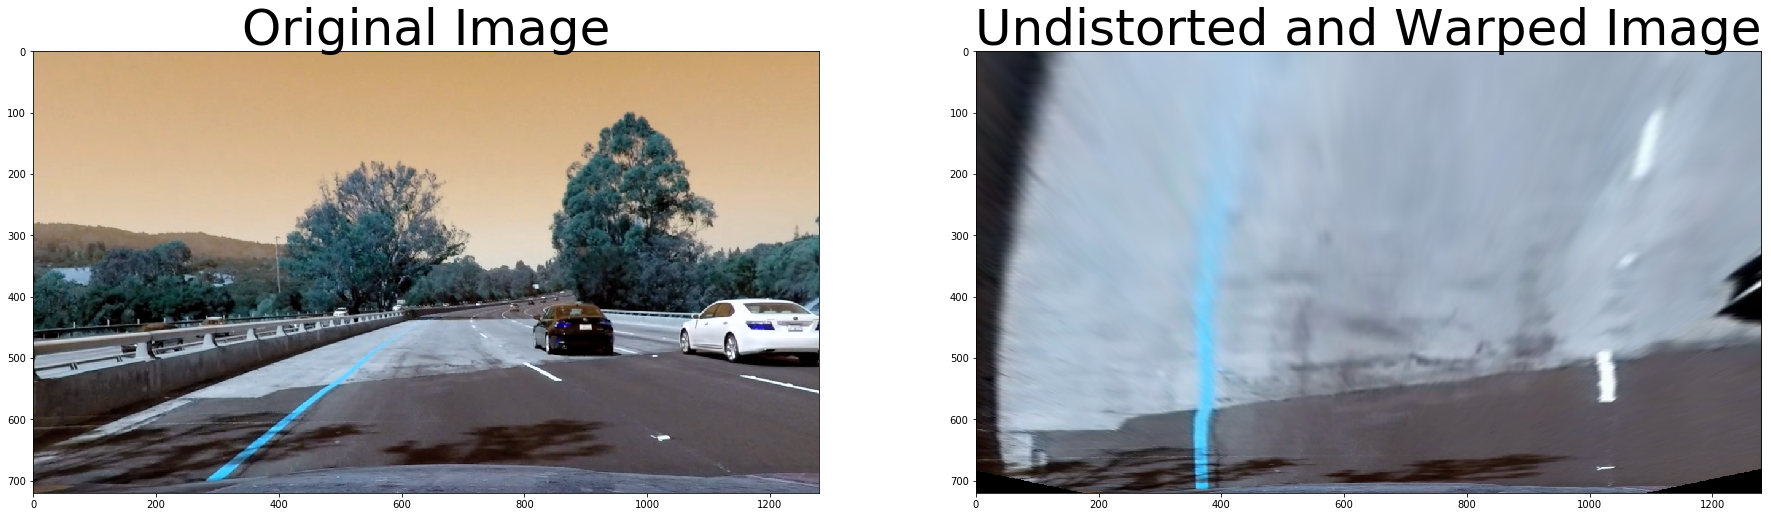

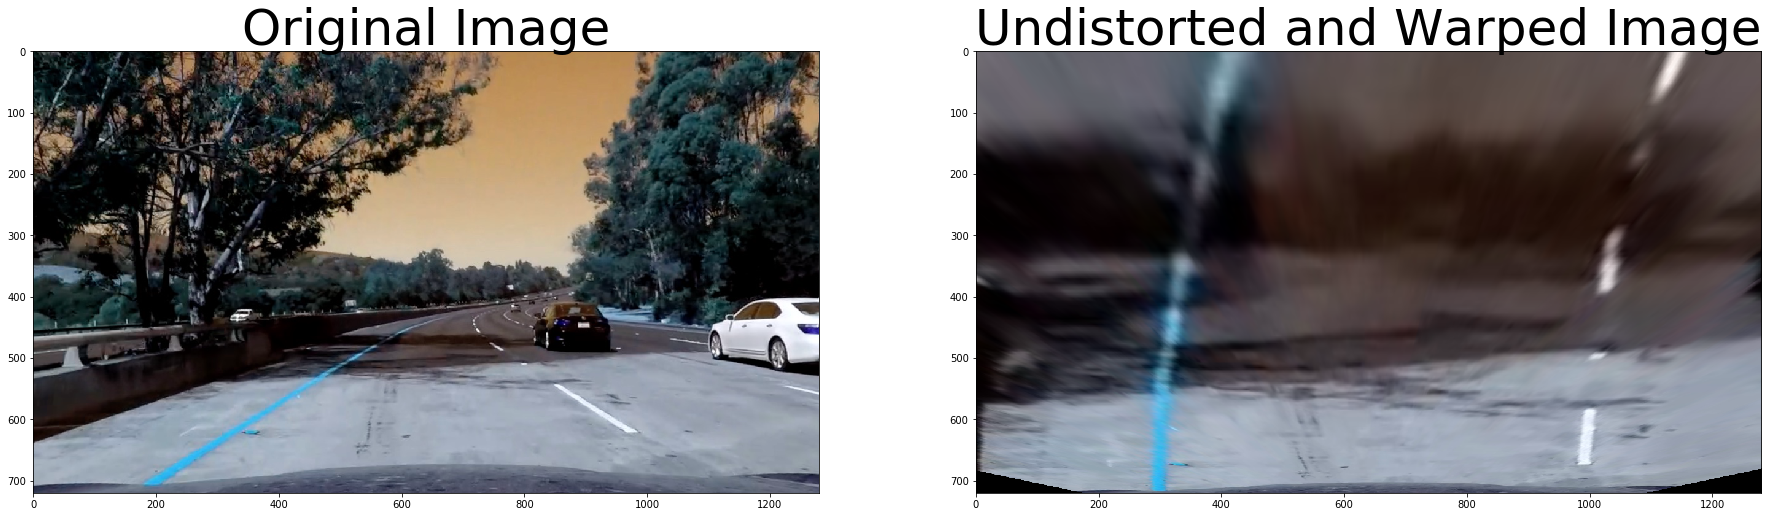

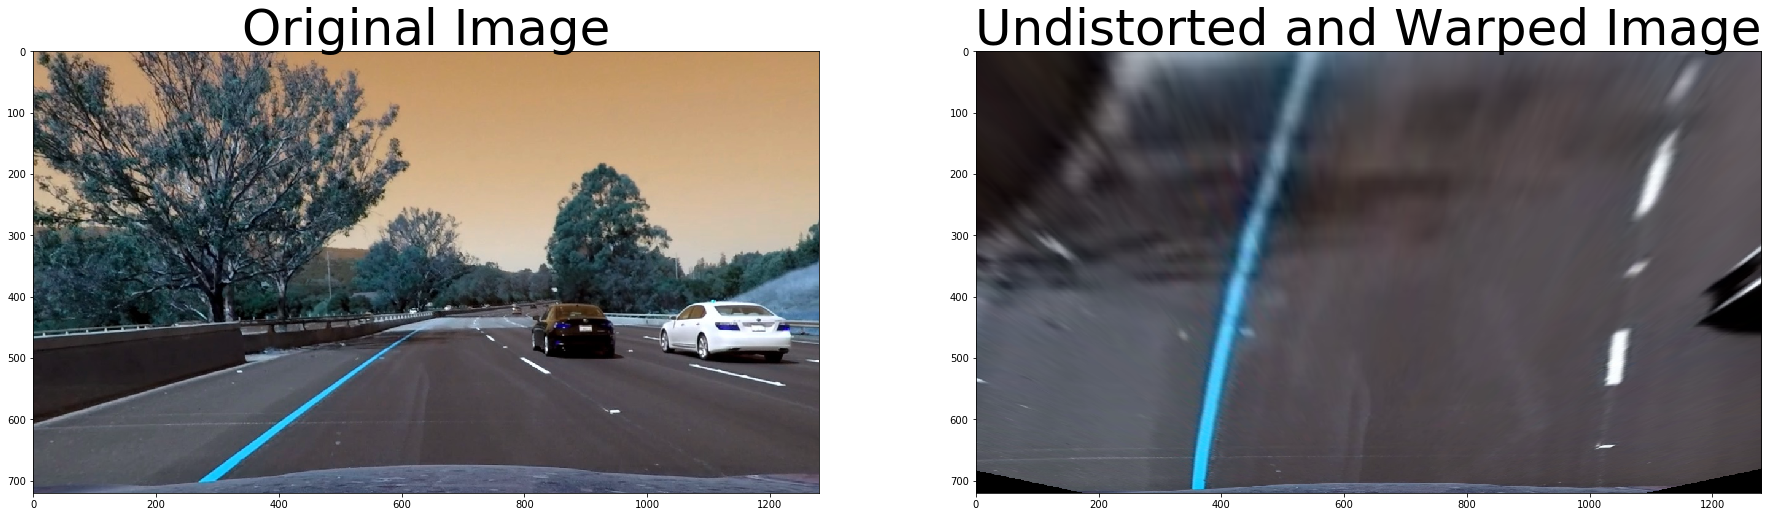

In [6]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y


# Make a list of calibration images
images = glob.glob('test_images/test*.jpg')

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    #undistort the image
    img = cal_undistort(img)
    unwarp, Minv = corners_unwarp(img, nx, ny)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(unwarp)
    ax2.set_title('Undistorted and Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()


## Gradient threshold functions
 The below defined functions apply following gradient theshold:
 * Absolute sobel threshold in x or y direction
 * Magnitude of x and y gradient
 * Direction of x and y gradient

In [7]:
#Define different threshold functions
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=90):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(10, 120)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, 0.6)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

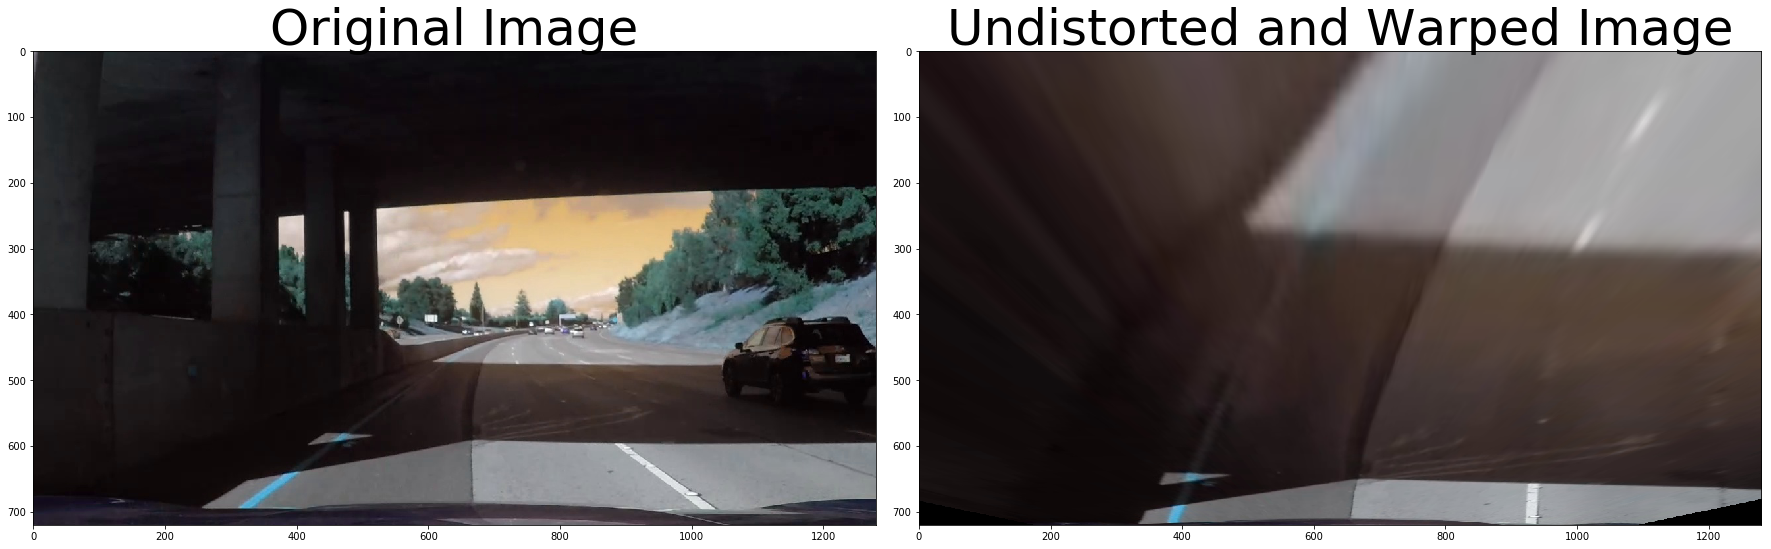

In [32]:
# Read an image and optimize color and gradient threshold for best lane detection
# The below image is extracted from the project video
exampleImg = cv2.imread('challenge_debug/orig_img130.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)

#warp and undistort
undist = cal_undistort(exampleImg)
undistwarp, Minv = corners_unwarp(undist, nx, ny)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(exampleImg)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistwarp)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


## Visualize the various gradient theshold on test image
 This is a trial and error approach to find out what technique works best. The test image chosen is extracted from project video from the section where road surface is of slightly different texture/color which makes it harder to detect lane.

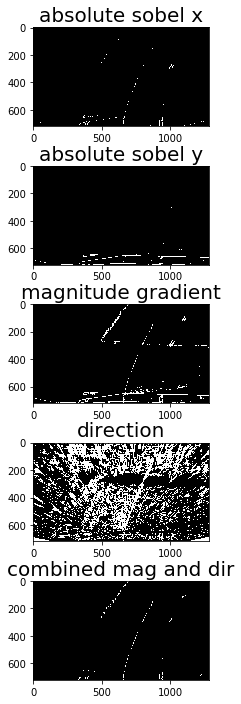

In [37]:
#Apply color and gradient threshold
fig, axs = plt.subplots(5,1, figsize=(16, 12))
fig.subplots_adjust(hspace = .4, wspace=.001)
axs = axs.ravel()

gradx_binary = abs_sobel_thresh(undistwarp, orient='x', thresh_min=20, thresh_max=255)
grady_binary = abs_sobel_thresh(undistwarp, orient='y', thresh_min=20, thresh_max=150)
mag_binary = mag_thresh(undistwarp, sobel_kernel=3, mag_thresh=(10, 120))
dir_binary = dir_threshold(undistwarp, sobel_kernel=15, thresh=(0.0, 0.6))

combined = np.zeros_like(dir_binary)
combined[ ((mag_binary == 1) & (dir_binary == 1))] = 1


axs[0].imshow(gradx_binary, cmap='gray')
axs[0].set_title('absolute sobel x', fontsize=20)

axs[1].imshow(grady_binary, cmap='gray')
axs[1].set_title('absolute sobel y', fontsize=20)

axs[2].imshow(mag_binary, cmap='gray')
axs[2].set_title('magnitude gradient', fontsize=20)

axs[3].imshow(dir_binary, cmap='gray')
axs[3].set_title('direction', fontsize=20)

axs[4].imshow(combined, cmap='gray')
axs[4].set_title('combined mag and dir', fontsize=20)

plt.show()

As seen in the result above, none of the gradient threshold functions work well on the example image extracted from project video. However, combined magnitude and direction threshold seems to be the best among all.

## Visualize various color space channels
 This is also a trial and error approach to visualize best color space channel and tune the corresponding threshold values. HLS, HSV and LUV colorspace channels are visualized below.

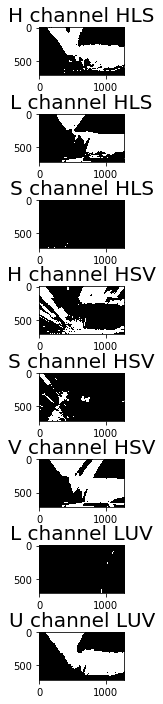

In [58]:
#Color channel thresholds(HLS)
imgHLS = cv2.cvtColor(undistwarp, cv2.COLOR_RGB2HLS)

imgHSV = cv2.cvtColor(undistwarp, cv2.COLOR_RGB2HSV)

imgLUV = cv2.cvtColor(undistwarp, cv2.COLOR_RGB2LUV)

#Set thresholds
h_thresh = (0, 50)
l_hls_thresh = (50, 130)
s_thresh = (100, 200)

v_thresh = (50, 150)

l_thresh = (200, 255)
u_thresh = (100, 255)

h_hsvthresh = (100, 200)
s_hsvthresh = (100, 200)


fig, axs = plt.subplots(8,1, figsize=(16, 12))
fig.subplots_adjust(hspace = .8, wspace=.001)
axs = axs.ravel()

H = imgHLS[:,:,0]
L_hls = imgHLS[:,:,1]
S = imgHLS[:,:,2]

V = imgHSV[:,:,2]

H_hsv = imgHSV[:,:,0]

S_hsv = imgHSV[:,:,1]

L = imgLUV[:,:,0]

U = imgLUV[:,:,1]


H_binary = np.zeros_like(H)
H_binary[(H > h_thresh[0]) & (H <= h_thresh[1])] = 1

L_hls_binary = np.zeros_like(L_hls)
L_hls_binary[(L > l_hls_thresh[0]) & (L <= l_hls_thresh[1])] = 1

S_binary = np.zeros_like(S)
S_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1

V_binary = np.zeros_like(V)
V_binary[(V > v_thresh[0]) & (V <= v_thresh[1])] = 1

L_binary = np.zeros_like(L)
L_binary[(L > l_thresh[0]) & (L <= l_thresh[1])] = 1

U_binary = np.zeros_like(U)
U_binary[(U > u_thresh[0]) & (L <= u_thresh[1])] = 1

H_HSVbinary = np.zeros_like(H_hsv)
H_HSVbinary[(H_hsv > h_hsvthresh[0]) & (H_hsv <= h_hsvthresh[1])] = 1

S_HSVbinary = np.zeros_like(S_hsv)
S_HSVbinary[(S_hsv > s_hsvthresh[0]) & (S_hsv <= s_hsvthresh[1])] = 1

U_binary = np.zeros_like(U)
U_binary[(U > u_thresh[0]) & (L <= u_thresh[1])] = 1

axs[0].imshow(H_binary, cmap='gray')
axs[0].set_title('H channel HLS', fontsize=20)

axs[1].imshow(L_hls_binary, cmap='gray')
axs[1].set_title('L channel HLS', fontsize=20)

axs[2].imshow(S_binary, cmap='gray')
axs[2].set_title('S channel HLS', fontsize=20)

axs[3].imshow(H_HSVbinary, cmap='gray')
axs[3].set_title('H channel HSV', fontsize=20)

axs[4].imshow(S_HSVbinary, cmap='gray')
axs[4].set_title('S channel HSV', fontsize=20)

axs[5].imshow(V_binary, cmap='gray')
axs[5].set_title('V channel HSV', fontsize=20)

axs[6].imshow(L_binary, cmap='gray')
axs[6].set_title('L channel LUV', fontsize=20)

axs[7].imshow(U_binary, cmap='gray')
axs[7].set_title('U channel LUV', fontsize=20)


plt.show()

As seen from the visualization above, it looks like a combination of S channel from HLS and L channel from LUV would likely detect both the lane markings well.

Next, RGB color space channels are visualized.

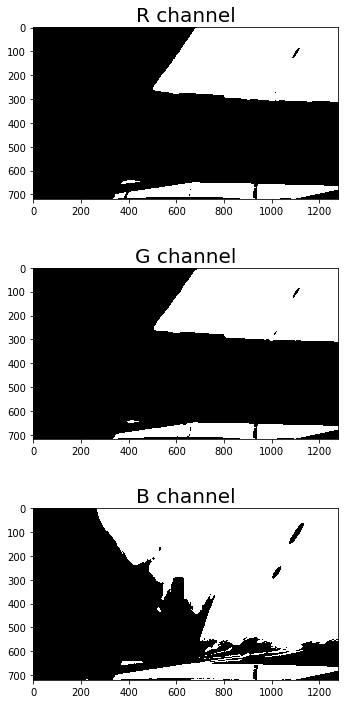

In [43]:
#Color channel thresholds(RGB)
imgRGB = cv2.cvtColor(undistwarp, cv2.COLOR_BGR2RGB)

#Set thresholds
r_thresh = (90, 200)
g_thresh = (100, 200)
b_thresh = (60, 180)

fig, axs = plt.subplots(3,1, figsize=(16, 12))
fig.subplots_adjust(hspace = .4, wspace=.001)
axs = axs.ravel()

R = imgRGB[:,:,0]
G = imgRGB[:,:,1]
B = imgRGB[:,:,2]

R_binary = np.zeros_like(R)
R_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1

G_binary = np.zeros_like(G)
G_binary[(G > g_thresh[0]) & (G <= g_thresh[1])] = 1

B_binary = np.zeros_like(B)
B_binary[(B > b_thresh[0]) & (B <= b_thresh[1])] = 1

axs[0].imshow(R_binary, cmap='gray')
axs[0].set_title('R channel', fontsize=20)

axs[1].imshow(G_binary, cmap='gray')
axs[1].set_title('G channel', fontsize=20)

axs[2].imshow(B_binary, cmap='gray')
axs[2].set_title('B channel', fontsize=20)

plt.show()

## Image preprocessing function
 Based on the analysis with various techniques above, below preprocessing function is defined. This function undistorts the image, transforms it and applies gradient and color threshold. A combination of magnitude and direction threshold and S channel from HLS and L channel from LUV colorspace(with appropriate thresholds) is used to form image binary.

In [12]:
# Define the complete image processing 
h_thresh = (0, 50)
l_thresh = (50, 130)
s_thresh = (100, 200)

v_thresh = (220, 250)

l_thresh = (200, 255)

def preprocess(img):
    # Undistort
    img_undistort = cal_undistort(img)
    
    # Perspective Transform
    img_unwarp, Minv = corners_unwarp(img_undistort, nx=9, ny=6)
    
    img_HLS = cv2.cvtColor(img_unwarp, cv2.COLOR_RGB2HLS)

    img_HSV = cv2.cvtColor(img_unwarp, cv2.COLOR_RGB2HSV)

    img_LUV = cv2.cvtColor(img_unwarp, cv2.COLOR_RGB2LUV)
    
    S = img_HLS[:,:,2]
    L = img_LUV[:,:,1]

    # Sobel Absolute (using default parameters)
    img_sobelAbs = abs_sobel_thresh(img_unwarp, orient='x', thresh_min=20, thresh_max=90)

    # Sobel Magnitude (using default parameters)
    img_sobelMag = mag_thresh(img_unwarp, sobel_kernel=3, mag_thresh=(25, 120))
    
    # Sobel Direction (using default parameters)
    img_sobelDir = dir_threshold(img_unwarp, sobel_kernel=3, thresh = (0.1, 0.8))
    
    combined_grad = np.zeros_like(img_sobelDir)
    combined_grad[ ((img_sobelMag == 1) & (img_sobelDir == 1))] = 1
    
    # HLS S-channel Threshold (using default parameters)
    S_binary = np.zeros_like(S)
    S_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    L_binary = np.zeros_like(L)
    L_binary[(L > l_thresh[0]) & (L <= l_thresh[1])] = 1

    # HLS L-channel Threshold (using default parameters)
    #img_LThresh = hls_lthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(L_binary)
    combined[(S_binary == 1) | (L_binary == 1) | (combined_grad ==1)] = 1
    return img_undistort, combined, Minv
    

### Test preprocessing function on one of the images

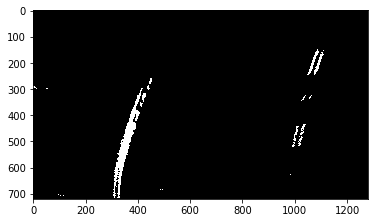

In [13]:
#Test Preprocess
PreProcess_img = cv2.imread('debug/orig_img130.jpg')
undist_preproc, Bin_preprocess, Minv = preprocess(PreProcess_img)
#print(img.shape)
plt.imshow(Bin_preprocess, cmap = 'gray')
plt.show()

### Sliding window line fit algorithm
The code for this function is from the project lesson

In [14]:
def sliding_window_linefit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
   # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        #Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
    
        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
         #Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        #If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    #  Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Below code lines are only for visualisation. This is commented out when running
    # project video
    
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #cv2.imwrite( 'output_images/rect.jpg', out_img)
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

    #plt.show()
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds



### Line fitting function using previously computed polynomial co-efficients

In [15]:
def polyfit_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new, right_fit_new = (None, None)
    if(len(leftx)!=0):
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if(len(rightx)!=0):
        right_fit_new = np.polyfit(righty, rightx, 2)
    
    #if left_fit_new is not None and right_fit_new is not None:
    #Visualization test
        #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        #left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
        #right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]

        # Create an image to draw on and an image to show the selection window
        #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        #window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        #left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        #left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        #left_line_pts = np.hstack((left_line_window1, left_line_window2))
        #right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        #right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        #right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    #plt.show()
    
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds



### Visualize the result from sliding window fit
Previously processed image from preprocessing function is used for visualsation

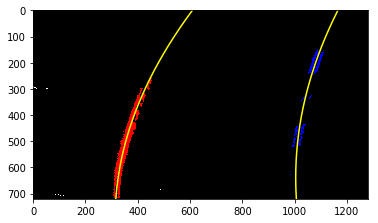

In [16]:
#Test sliding window and previous fit functions

# Create an output image to draw on and  visualize the result
out_img = np.dstack((Bin_preprocess, Bin_preprocess, Bin_preprocess))*255

nonzero = Bin_preprocess.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

left_fit, right_fit, left_lane_inds, right_lane_inds = sliding_window_linefit(Bin_preprocess)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

ploty = np.linspace(0, Bin_preprocess.shape[0]-1, Bin_preprocess.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.show()



### Compute radius of curvature and distance of vehicle from lane center
 Radius of curvature is computed using the formula from the project lesson. Distance of vehicle from the center of the lane is the distance between the mid point of the image and the mid point of base position of left and right lane markings.

In [17]:
#Compute curvature
def compute_curvature(binary_warped, left_fit_new, right_fit_new, left_lane_inds, right_lane_inds):
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1280 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    if len(leftx) != 0 and len(rightx) != 0:
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        #print(left_curverad, right_curverad)
        
    # Now our radius of curvature is in meters
    h = binary_warped.shape[0]
    if right_fit_new is not None and left_fit_new is not None:
        car_position = binary_warped.shape[1]/2
        l_fit_x_int = left_fit_new[0]*h**2 + left_fit_new[1]*h + left_fit_new[2]
        r_fit_x_int = right_fit_new[0]*h**2 + right_fit_new[1]*h + right_fit_new[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
        #print(center_dist)
    return left_curverad, right_curverad, center_dist
    


### Draw lane on the original image
 Once polynomial fit co-efficients are available, they are used draw line on warped binary image. Warped binary image with lane drawn on it is transformed back to the original image space using inverse perspective matrix.

In [18]:
def draw_lane(undist_img, binary_warped, left_fit, right_fit, Minv):
    new_img = np.copy(undist_img)
    if left_fit is None or right_fit is None:
        return undist_img
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    h,w = binary_warped.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    
    h,w = binary_warped.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([pts]), (0,255, 0))
    cv2.polylines(window_img, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(window_img, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(window_img, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

    

### Visualise draw lane on example image
 Previously computed fit co-efficients from sliding window is used to draw lane. Lane is drawn on undistorted version of the original image.

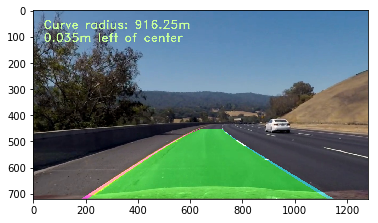

In [21]:

left_fit_new, right_fit_new, left_lane_inds, right_lane_inds = polyfit_prev_fit(Bin_preprocess, left_fit, right_fit)
left_curverad, right_curverad, center_dist = compute_curvature(Bin_preprocess, left_fit_new, right_fit_new, left_lane_inds, right_lane_inds)
result = draw_lane(undist_preproc, Bin_preprocess, left_fit_new, right_fit_new, Minv)
result_out = draw_data(result, (left_curverad + right_curverad)/2, center_dist)

cv2.imwrite('check.jpg', result_out)
plt.imshow(result_out)
plt.show()

### Draw curvature and distance from center data on the 

In [20]:
def draw_data(undist_img, curv_rad, center_dist):
    new_img = np.copy(undist_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

### Line class to track poly fit
 Left and right lane fit are tracked seperately using line class instance for left and right lanes. Following functionalities are embedded in this class:
 * Tracking of fit co-efficients
     Fit co-efficients detections are tracked over 3 cycles. If no fit is detected for 3 consecutive cycles then fresh search is shall be made using sliding window
 * Averaging of fit co-efficients
     Fit co-efficients of last 8 cycles is tracked and averaged. Oldest fit co-efficients are discarded in each cycle.
 * Sanity check of each new fit
     New fit co-efficient values are compared with current running average and if the difference is beyond a threshold, current fit values are discarded.
 * Plausibility check for curvature
     Curvture is checked for implausible value. If too small, then fit is discared.

In [22]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in t coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #number of detected pixels
        self.px_count = None
        
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 8:
                # Implausible fit co-efficients
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 8:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-8:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)
   
    def update_curvature(self, curve):
        if(curve<100):
            #Curvature implausible
            self.detected = False
        else:
            #print(curve)
            self.radius_of_curvature = curve
        
                

## Pipeline for processing image frames from video

In [30]:
global i
i = 0

def process_image(img):
    new_img = np.copy(img)
    global i
    undist_img, img_bin, Minv = preprocess(img)
    cv2.imwrite('challenge_debug/orig_img'+str(i)+'.jpg', new_img)
    plt.imsave('challenge_debug/debug_img'+str(i)+'.jpg', img_bin)
    i = i+1

    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds = sliding_window_linefit(img_bin)
    else:
        #print('both lines detected')
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        #If the difference between base position of left and right lines is too less, 
        #then the fit is not good. Discard.
        if (x_int_diff < 200):
            print('x_base diff too low')
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(undist_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = compute_curvature(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
        l_line.update_curvature(rad_l)
        r_line.update_curvature(rad_r)
    else:
        img_out = undist_img
        
    #if fit_found == True:
     #   l_line.update_fit(left_fit, left_curverad)
      #  r_line.update_fit(right_fit, right_curverad)
    #print('current fit', len(l_line.current_fit))
    return img_out
    

In [31]:
from moviepy.editor import *
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'challenge_video_output_3.mp4'
video_input1 = VideoFileClip('challenge_video.mp4').subclip(0,20)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)


[MoviePy] >>>> Building video challenge_video_output_3.mp4
[MoviePy] Writing video challenge_video_output_3.mp4



 26%|██▌       | 155/600 [03:13<09:18,  1.25s/it]


 52%|█████▏    | 309/600 [06:19<06:10,  1.27s/it]


 77%|███████▋  | 463/600 [09:38<02:55,  1.28s/it]


100%|██████████| 600/600 [12:28<00:00,  1.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output_3.mp4 

CPU times: user 12min 27s, sys: 40.6 s, total: 13min 8s
Wall time: 12min 29s


## Problems or issues faced
* Choosing the source and destination points for perspective transform
* Line detection in regions where road surface is of different texture or has shadow - This was solved by using L channel from LUV colorspace.
* Fine tuning threshold values for color and gradient - This was particularly time taking due to a lot of combinations of color space and gradient techniques

## Failure cases:
* The pipeline has been tuned for images from video which is on a sunny day. However, different weather conditions may present completely different type of images especially, snow or rainy weather. The pipeline may not be able to detect lanes in such conditions as the road surface appearance will change.
  Hence it may be necessary to tune the pipeline with images from different weather conditions and also when the sun is facing the vehicle or there is reflection from sun.